In [1]:
import pandas as pd

from corncast import Location, corn_forecast, parse_windspeed

ImportError: cannot import name 'dec_plot' from 'corncast' (/home/smerdis/Dropbox/code/corncast/corncast/corncast.py)

In [ ]:
rose = Location("Mt. Rose Summit", 39.3144, -119.9173)
berk = Location("Berkeley", 37.8715, -122.27)

Calling: /points/39.3144,-119.9173
Calling: https://api.weather.gov/gridpoints/REV/40,97/stations
Calling: /stations/SLIDE/observations?start=2023-11-16T15%3A59%3A33Z&end=2023-11-21T15%3A59%3A33Z


/home/smerdis/Dropbox/code/corncast/corncast/corncast.py:209: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs_df_full = pd.concat([pd.json_normalize(o) for o in loc.get_obs(start, end)], ignore_index=True)


Timestamp before: 2023-11-21T15:20:00+00:00
Timestamp after: 2023-11-21 15:20:00+00:00
Calling: /points/39.3144,-119.9173
Calling: https://api.weather.gov/gridpoints/REV/40,97/forecast/hourly


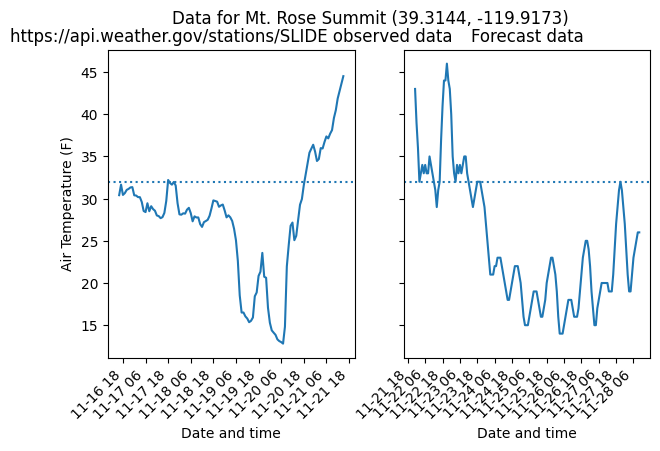

Freeze-thaw cycle detected on 2 days:
                       date  freeze_thaw
1 2023-11-17 00:00:00+00:00         True
4 2023-11-20 00:00:00+00:00         True
               date_nearest6  max_above_freezing  max_below_freezing
0  2023-11-16 12:00:00+00:00               False                True
1  2023-11-16 18:00:00+00:00               False                True
2  2023-11-17 00:00:00+00:00               False                True
3  2023-11-17 06:00:00+00:00               False                True
4  2023-11-17 12:00:00+00:00               False                True
5  2023-11-17 18:00:00+00:00                True                True
6  2023-11-18 00:00:00+00:00               False                True
7  2023-11-18 06:00:00+00:00               False                True
8  2023-11-18 12:00:00+00:00               False                True
9  2023-11-18 18:00:00+00:00               False                True
10 2023-11-19 00:00:00+00:00               False                True
11 2023-11-

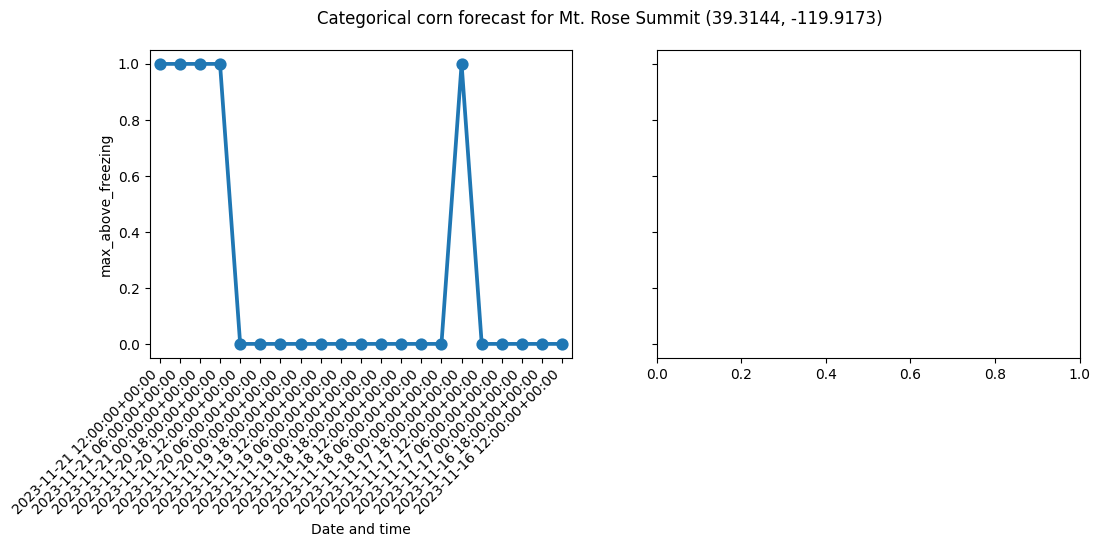

In [ ]:
(obs_df, obs_24h_df, obs_6h_df, fcst_df) = corn_forecast(rose)

In [ ]:
from datetime import datetime, timedelta
now = datetime.now()
obs_period = timedelta(days=5)
start = now-obs_period
end = now
tcol = 'tempF'

#[o['elevation'] for o in rose.get_obs(start, end)]

<Axes: xlabel='Date and time', ylabel='tempF'>

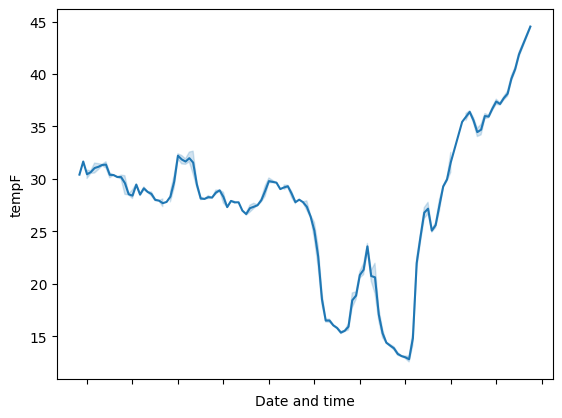

In [ ]:
dec_plot(data=obs_df, x='datehour', y='tempF')

<Axes: xlabel='Date and time', ylabel='max_above_freezing'>

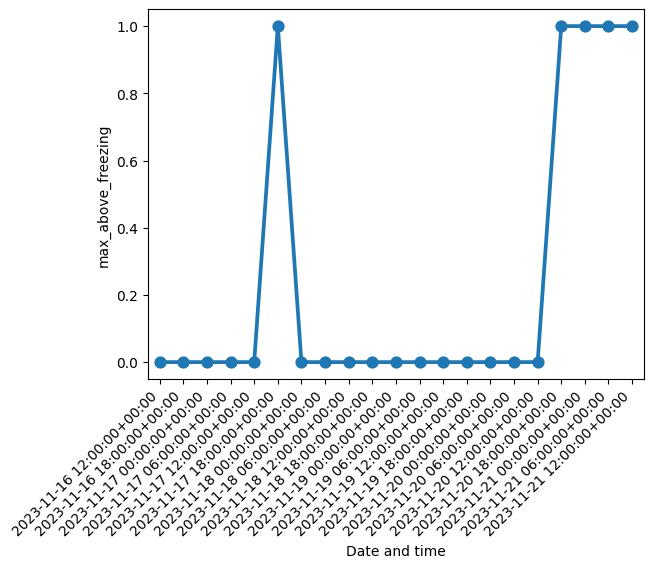

In [ ]:
dec_cat_plot(data=obs_6h_df, x='date_nearest6', y='max_above_freezing')

In [ ]:
obs_6h_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   date_nearest6       21 non-null     datetime64[ns, UTC]
 1   max_above_freezing  21 non-null     bool               
 2   max_below_freezing  21 non-null     bool               
dtypes: bool(2), datetime64[ns, UTC](1)
memory usage: 338.0 bytes
